### Alice combo notebook

In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

sns.set()

In [2]:
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('../data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('../data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [4]:
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(25)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
29      54094
167     46405
780     43841
778     38194
52      36085
812     35178
80      31391
570     30616
55      27812
39      25275
37      23726
30      23495
786     23026
35      22470
76      20922
33      19683
3       18130
77      17270
616     16890
733     15920
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com
812,mail.google.com


In [5]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [6]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [7]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [8]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [9]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195244077552184
CPU times: user 5.62 s, sys: 3.23 ms, total: 5.62 s
Wall time: 5.63 s


In [10]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [11]:
times = ['time%s' % i for i in range(1, 11)]
full_df[times].describe()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
count,336358,331406,326994,323503,320170,317061,314137,311375,308568,305858
unique,313976,309442,305547,302155,298925,296163,293715,291220,288582,286002
top,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54
freq,7,7,8,9,7,7,7,7,7,7
first,2013-01-12 08:05:57,2013-01-12 08:05:57,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
last,2014-12-05 23:26:53,2014-12-05 23:26:53,2014-12-05 23:56:23,2014-12-05 23:56:23,2014-12-05 20:24:08,2014-12-05 19:10:09,2014-12-05 19:10:03,2014-12-05 19:10:03,2014-12-05 19:10:03,2014-12-05 19:10:03


### FREERIDE

In [12]:
def get_last_time(rows):
    res = pd.to_datetime('2014-02-20 10:02:45')
    for x in rows:
        if (not pd.isnull(x)):
            res = x
        else:
            return res
    return res

def  get_time_diff (row): 
    time_length = row.shape[0] - 1 
    time_diff = [0]*time_length 
    i = 0 
    while (i < time_length)and pd.notnull(row[i+1]): 
        time_diff[i] = (row[i+1] - row[i]) /np.timedelta64(1,'s') 
        i += 1 
    return  time_diff

def get_total_time(row): 
    time_length = row.shape[0] - 1 
    i = time_length 
    while pd.isnull( row [ i ]): 
        i -= 1 
    return (row[i] - row[0]) / np.timedelta64(1,'s')

def get_last_site(row):
    for x in row:
        if (x != 0):
            res = x
        else:
            return res
    return res

def apply_is_yb(row):
    last = get_last_site(row)
    return is_site(last, youtube_ids)

def apply_is_fb(row):
    last = get_last_site(row)
    return is_site(last, facebook_ids)

def is_site(x, l):
    if x in l:
      return 1 
    return 0

def is_long_session(x):
    if x < 3:
        return 0
    elif x < 5:
        return 1
    elif x < 10:
        return 2
    elif x < 30:
        return 3
    elif x < 40:
        return 4
    return 5

def get_quater(x):
    if x > 0 and x < 5:
        return 1
    elif x > 4 and x < 11:
        return 2
    elif x > 6 and x < 10:
        return 3
    return 4

def seasons(a):
    if a <= 2 or a == 12:
        return 1
    elif a > 2 and a <= 5:
        return 2
    elif a > 5 and a <= 8:
        return 3
    elif a > 8 and a <= 11:
        return 4

In [94]:
# Dataframe for new features
full_add_df = pd.DataFrame(index=full_df.index)

full_add_df['start_month'] = full_df['time1'].apply(lambda x: x.month)
full_add_df['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
full_add_df['start_day'] = full_df['time1'].apply(pd.datetime.weekday)
full_add_df['stop_hour'] = full_df[times].apply(get_last_time, axis=1).apply(lambda x: x.hour)
full_add_df['stop_month'] = full_df[times].apply(get_last_time, axis=1).apply(lambda x: x.month)
full_add_df['stop_day'] = full_df[times].apply(get_last_time, axis=1).apply(pd.datetime.weekday)
full_add_df['start_day_year'] = full_df['time1'].apply(lambda ts: ts.timetuple().tm_yday)
full_add_df['stop_day_year'] = full_df[times].apply(get_last_time, axis=1).apply(lambda ts: ts.timetuple().tm_yday)
full_add_df['start_minute'] =   full_df['time1'].apply(lambda ts: ts.minute)
full_add_df['stop_minute'] =  full_df[times].apply(get_last_time, axis=1).apply(lambda x: x.minute)

In [17]:
full_add_df['mm'] = full_df['time1'].apply(lambda ts: ts.month).astype(np.int8)
full_add_df['yyyy'] = full_df['time1'].apply(lambda ts: ts.year).astype(np.int8)
full_add_df['yyyymm'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype('float64')
full_add_df['hhmm'] = full_df['time1'].apply(lambda ts: ts.hour + ts.minute)
full_add_df['hhmm_dum'] = full_df['time1'].apply(lambda ts: str(ts.hour) +  str(ts.minute)).astype('float64')
full_add_df['quarter'] = full_add_df['mm'].apply(get_quater).astype('int')
full_add_df['holiday']     = (full_df['time1'].dt.dayofweek >= 5).astype(int) 
full_add_df['day_of_week'] = (full_df['time1'].dt.dayofweek).astype(int)

In [22]:
full_add_df['morning'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour <= 11) & (ts.hour >= 7)) else 0).astype('int')
full_add_df['day'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 12) & (ts.hour <= 18)) else 0).astype('int')
full_add_df['early_evening'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 19) & (ts.hour <= 21)) else 0).astype('int')
full_add_df['late_evening'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 22) & (ts.hour <= 23)) else 0).astype('int')

full_add_df['evening'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 19) & (ts.hour <= 23)) else 0).astype('int')
full_add_df['night'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 0) & (ts.hour <= 6)) else 0).astype('int')

In [23]:
full_add_df['early_morning'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 7) & (ts.hour <= 9)) else 0).astype('int')
full_add_df['late_morning'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 10) & (ts.hour <= 11)) else 0).astype('int')

In [24]:
## Add time diff
full_time = full_df[times]
time_diff = []
for row in full_time.values:
    time_diff.append (get_time_diff (row))
time_diff = np.log1p(np.array(time_diff).astype(float))

time_names = ['time_diff'+str(j) for j in range(1,10)] 
for ind,column_name in enumerate(time_names): 
    full_add_df[column_name] = time_diff[:,ind] 
    
full_add_df.head()

,start_month,start_hour,start_day,stop_hour,stop_month,stop_day,start_minute,stop_minute,oct,hhmm,...,late_morning,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
session_id,,,,,,,,,,,,,,,,,,,,,
21669,1,8,5,8,1,5,5,5,0,13,...,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
54843,1,8,5,9,1,5,37,7,0,45,...,0,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
77292,1,8,5,8,1,5,50,50,0,58,...,0,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000
114021,1,8,5,8,1,5,50,50,0,58,...,0,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147
146670,1,8,5,8,1,5,50,50,0,58,...,0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000


In [27]:
# minuties feature
full_df['min'] = full_df[times].min(axis=1)
full_df['max'] = full_df[times].max(axis=1)
full_add_df['minutes'] = ((full_df['max'] - full_df['min']) / np.timedelta64(1, 'm')).round(2)
full_add_df['seconds'] = (full_df['max'] - full_df['min']) / np.timedelta64(1, 's')

full_df.drop(['min','max'], inplace=True, axis=1)

In [28]:
full_add_df['short'] = full_add_df['minutes'].map(lambda x: x < 0.8).astype(np.int8)
full_add_df['long'] = full_add_df['minutes'].map(lambda x: x >= 0.8).astype(np.int8)

In [29]:
hosts = pd.read_pickle('../data/site_dic.pkl')
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # rename index for the future merge
full_df = pd.merge(full_df, hosts, how='left', on='site1')

full_add_df['big_site'] = full_df['len'].apply(lambda x: x > 5).astype(np.int8)
full_add_df['typical_site'] = full_df['len'].apply(lambda x: x == 3).astype(np.int8)
full_add_df['fr_domain'] = full_df['domain'].map(lambda x: x in ('fr')).astype(np.int)
full_add_df['gov_domain'] = full_df['domain'].map(lambda x: x in ('gov')).astype(np.int)
full_add_df['domain'] = full_df['domain']

In [34]:
full_add_df['duration'] = (full_df[times].apply(get_last_time, axis=1) - full_df['time1']).astype(int).apply(lambda x: x/10e8)
full_add_df['duration'] = full_add_df['duration'].apply(is_long_session).astype('int')

In [37]:
site_dict  =  {} 
for  row  in  full_sites.values : 
    for  site_id  in  np.unique ( row ): 
        if  site_id  in  site_dict : 
            site_dict [ site_id ]  +=  1 
        else : 
            site_dict [ site_id ]  =  1 
site_dict.pop(0)

30500

In [38]:
#Getting Unique Counts
unique_count = []
for row in full_sites.values:
    unique = np.unique (row)
    if 0 in unique:
        unique_count.append(len(unique) - 1)
    else:
        unique_count.append(len(unique))
unique_count = np.array(unique_count).reshape(-1,1)
unique_count[:10] #print few

full_add_df['unique'] = unique_count
full_add_df['unique_less'] = full_add_df['unique'].apply(lambda ts: 1 if (ts < 5) else 0)

In [40]:
absolutely_unique_count  =  np.zeros((full_sites.shape[0], 1 ), dtype = int ) 
ind  =  0 
for  row  in  full_sites.values: 
    unique  =  np.unique ( row ) 
    absolutely_unic_row  =  {} 
    for site_id in unique: 
        if (site_id !=0) and (site_dict[site_id] == 1) and (site_id not in absolutely_unic_row): 
            absolutely_unique_count [ind]  +=  1 
            absolutely_unic_row [site_id]  =  1 
    ind  +=  1
full_add_df['absolutely_unique_count'] = absolutely_unique_count
absolutely_unique = (absolutely_unique_count > 0 ).astype(int)
full_add_df ['have_absolutely_unique'] = absolutely_unique

In [42]:
total_time = []
for row in full_time.values:
    total_time.append(get_total_time(row))
total_time = np.array(total_time).reshape(-1,1).astype(int)

full_add_df['total_time'] =  total_time 
full_add_df['total_time'] =  np.log1p(full_add_df['total_time'].values)

In [43]:
full_add_df['work_hours'] = full_add_df['start_hour'].apply(lambda ts: 1 if 
                                             (((ts >=10)&(ts <=11)) | 
                                              (ts == 14)) else 0)
full_add_df['non_work_hours'] = full_add_df['stop_hour'].apply(lambda ts: 1 if 
                                             (((ts >=14)&(ts <=15)) | 
                                              (ts >= 10) & (ts <= 11)) else 0)

In [45]:
full_add_df['hot_minutes'] = full_add_df[['start_day', 'minutes']].apply(lambda ts: 1 if 
                                             ((ts.start_day == 0) & (ts.minutes < 9) | 
                                             (ts.start_day == 1) & (ts.minutes < 6) |
                                             (ts.start_day == 2) & (ts.minutes < 3) |
                                             (ts.start_day == 3) & (ts.minutes < 6) |
                                             (ts.start_day == 4) & (ts.minutes < 6) |
                                             (ts.start_day == 5) & (ts.minutes < 3) |
                                             (ts.start_day == 6) & (ts.minutes < 1) ) else 0, axis=1)
full_add_df[['hot_minutes', 'start_day', 'minutes']][:5]

,hot_minutes,start_day,minutes
session_id,,,
21669,1,5,0.00
54843,0,5,29.77
77292,1,5,0.07
114021,1,5,0.05
146670,1,5,0.03


In [46]:
full_add_df['gov_domain_hours'] = full_add_df[['start_hour', 'domain']].apply(lambda ts: 1 if 
                                             ((ts.start_hour > 9) & (ts.start_hour < 19) & 
                                             (ts.domain == 'gov')) else 0, axis=1)
full_add_df[['gov_domain_hours', 'start_hour', 'domain']][:5]

,gov_domain_hours,start_hour,domain
session_id,,,
21669,0,8,com
54843,0,8,fr
77292,0,8,net
114021,0,8,com
146670,0,8,fr


In [47]:
full_add_df['hot_minutes_in_hour'] = full_add_df[['start_hour', 'minutes']].apply(lambda ts: 1 if 
                                             ((ts.start_hour > 8) & (ts.start_hour < 20) & 
                                             (ts.minutes < 8)) else 0, axis=1)
full_add_df[['hot_minutes_in_hour', 'start_day', 'minutes']][:5]

,hot_minutes_in_hour,start_day,minutes
session_id,,,
21669,0,5,0.00
54843,0,5,29.77
77292,0,5,0.07
114021,0,5,0.05
146670,0,5,0.03


In [48]:
full_add_df['stop_minutes_in_hour'] = full_add_df[['stop_hour', 'minutes']].apply(lambda ts: 1 if 
                                             ((ts.stop_hour > 8) & (ts.stop_hour < 19) & 
                                             (ts.minutes < 9)) else 0, axis=1)
full_add_df[['stop_minutes_in_hour', 'minutes']][:5]

,stop_minutes_in_hour,minutes
session_id,,
21669,0,0.00
54843,0,29.77
77292,0,0.07
114021,0,0.05
146670,0,0.03


In [49]:
full_add_df['weekday'] = full_df['time1'].dt.weekday

In [50]:
full_add_df['season'] = full_df['time1'].dt.month.apply(seasons)
full_add_df['is_summer'] = full_df['time1'].dt.month.apply(lambda m: 1 if m in [6,7,8] else 0)
full_add_df['startm_per_sec'] = full_add_df['seconds']**2 / (full_add_df['start_month']+0.0000000000000000001)

In [51]:
def sum_items(a):
    count = 0
    for i in a:
        if i != 0:
            count += 1
    return count

full_add_df['min'] = full_df[times].min(axis=1)
full_add_df['max'] = full_df[times].max(axis=1)

full_add_df['sites_per_session'] = full_sites.agg(sum_items, axis=1)

full_add_df['time_per_site'] = full_add_df['seconds'] / full_add_df['sites_per_session']

full_add_df['is_evening'] = full_add_df['start_hour'].apply(lambda x: 1 if x >= 19 else 0)
full_add_df['stm_per_weekday'] = (full_add_df['weekday']**2 / full_add_df['start_month'])
full_add_df['sec_per_season'] = full_add_df['seconds'] / full_add_df['season']
full_add_df['site1'] = full_df['site1']**2/100
full_add_df['is_daylight'] = full_add_df['start_hour'].apply(lambda h: 1 if h in range(11,19) else 0)
full_add_df['end_time'] = full_add_df['max'].apply(lambda ts: 100 * ts.hour + ts.minute).astype('float64')
full_add_df['end_time_eve'] = full_add_df['end_time'].apply(lambda ti: 1 if ti > 1600 else 0)
def last(a):
    for i in a:
        if i != 0:
            x = i
        else:
            break
    return x
full_add_df['last_site'] = full_sites.apply(last, axis = 1)
full_add_df['last_site_log'] = np.log(full_add_df['last_site'])
full_add_df.head()

,start_month,start_hour,start_day,stop_hour,stop_month,stop_day,start_minute,stop_minute,oct,hhmm,...,time_per_site,is_evening,stm_per_weekday,sec_per_season,site1,is_daylight,end_time,end_time_eve,last_site,last_site_log
session_id,,,,,,,,,,,,,,,,,,,,,
21669,1,8,5,8,1,5,5,5,0,13,...,0.0,0,25.0,0.0,36.65,0,954.0,0,55,4.007333
54843,1,8,5,9,1,5,37,7,0,45,...,446.5,0,9.0,446.5,410.97,0,1420.0,0,55,4.007333
77292,1,8,5,8,1,5,50,50,0,58,...,0.4,0,25.0,4.0,125.44,0,858.0,0,946,6.852243
114021,1,8,5,8,1,5,50,50,0,58,...,0.3,0,1.0,3.0,49.00,0,1021.0,0,946,6.852243
146670,1,8,5,8,1,5,50,50,0,58,...,0.2,0,0.0,2.0,279.72,0,1154.0,0,947,6.853299


In [52]:
with open(r"../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
facebook_ids = []
youtube_ids = []

for key in list(site_dict.keys()):
    if 'facebook' in key:
        facebook_ids.append(site_dict[key])
    if 'youtube' in key:
        youtube_ids.append(site_dict[key])

def is_site(x, l):
    if x in l:
      return 1 
    return 0
video_ids = []
socnet_ids = []
mail_ids = []
search_ids = []
prof_ids = []
other = []
for key in list(site_dict.keys()):
    if ('facebook' in key) or ('twitter' in key) or ('vk' in key) or ('gram' in key) or ('tumblr' in key) or ('reddit' in key):
        socnet_ids.append(site_dict[key])
    elif ('youtube' in key) or  ('video' in key) or  ('vimeo' in key) or ('vine' in key):
        video_ids.append(site_dict[key])
    elif ('mail' in key):
        mail_ids.append(site_dict[key])
    elif ('google' in key) or  ('yahoo' in key) or  ('bing' in key) or ('yandex' in key):
        search_ids.append(site_dict[key])
    elif ('wiki' in key) or  ('sci' in key) or  ('annotathon' in key) or ('oracle' in key) or ('code' in key) or ('soft' in key):
        prof_ids.append(site_dict[key])   
    else:
        other.append(site_dict[key])
ids = [other, video_ids, socnet_ids, mail_ids, search_ids, prof_ids]
sites_type_dic = {}
i = -1
for gr in ids:
    i += 1
    for site in gr:
        sites_type_dic[site] = i
def site_type_func(x):
    if x in sites_type_dic.keys():
        return sites_type_dic[x]
    else:
        return 0

In [53]:
full_add_df['yb start'] = full_df['site1'].apply(lambda x: is_site(x, youtube_ids))
full_add_df['fb start'] = full_df['site1'].apply(lambda x: is_site(x, facebook_ids))
sites_t = ['site%stype' %i for i in range(1, 11)]
full_add_df['yb end'] = full_add_df['last_site'].apply(lambda x: is_site(x, youtube_ids))
full_add_df['fb end'] = full_add_df['last_site'].apply(lambda x: is_site(x, facebook_ids))
full_add_df['site1type'] = full_sites['site1'].apply(site_type_func)
full_add_df['site2type'] = full_sites['site2'].apply(site_type_func)
full_add_df['site3type'] = full_sites['site3'].apply(site_type_func)
full_add_df['site4type'] = full_sites['site4'].apply(site_type_func)
full_add_df['site5type'] = full_sites['site5'].apply(site_type_func)
full_add_df['site6type'] = full_sites['site6'].apply(site_type_func)
full_add_df['site7type'] = full_sites['site7'].apply(site_type_func)
full_add_df['site8type'] = full_sites['site8'].apply(site_type_func)
full_add_df['site9type'] = full_sites['site9'].apply(site_type_func)
full_add_df['site10type'] = full_sites['site10'].apply(site_type_func)
full_add_df['siteseq'] = full_add_df[sites_t].astype(str).sum(axis=1)
full_add_df['seconds1'] = (full_df['time2'] - full_df['time1']) / np.timedelta64(1, 's')
full_add_df['seconds2'] = (full_df['time3'] - full_df['time2']) / np.timedelta64(1, 's')
full_add_df['seconds3'] = (full_df['time4'] - full_df['time3']) / np.timedelta64(1, 's')
full_add_df['seconds4'] = (full_df['time5'] - full_df['time4']) / np.timedelta64(1, 's')
full_add_df['seconds5'] = (full_df['time6'] - full_df['time5']) / np.timedelta64(1, 's')
full_add_df['seconds6'] = (full_df['time7'] - full_df['time6']) / np.timedelta64(1, 's')
full_add_df['seconds7'] = (full_df['time8'] - full_df['time7']) / np.timedelta64(1, 's')
full_add_df['seconds8'] = (full_df['time9'] - full_df['time8']) / np.timedelta64(1, 's')
full_add_df['seconds9'] = (full_df['time10'] - full_df['time9']) / np.timedelta64(1, 's')
full_add_df.fillna(0,inplace=True)
full_add_df.head()

,start_month,start_hour,start_day,stop_hour,stop_month,stop_day,start_minute,stop_minute,oct,hhmm,...,siteseq,seconds1,seconds2,seconds3,seconds4,seconds5,seconds6,seconds7,seconds8,seconds9
session_id,,,,,,,,,,,,,,,,,,,,,
21669,1,8,5,8,1,5,5,5,0,13,...,4.400000e+09,0.0,0.0,0.0,1.0,18.0,16.0,0.0,18.0,0.0
54843,1,8,5,9,1,5,37,7,0,45,...,4.444000e+09,0.0,0.0,9.0,16.0,14.0,38.0,12.0,30.0,31.0
77292,1,8,5,8,1,5,50,50,0,58,...,5.500000e+03,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0
114021,1,8,5,8,1,5,50,50,0,58,...,5.050000e+08,2.0,0.0,1.0,108.0,0.0,106.0,180.0,0.0,0.0
146670,1,8,5,8,1,5,50,50,0,58,...,5.000000e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
full_add_df['hot_minutes_by_day'] = full_add_df[['start_day', 'minutes']].apply(lambda ts: 1 if 
                                             (((ts.start_day >= 0) & (ts.start_day <= 1) & (ts.minutes < 10)) | 
                                             ((ts.start_day >= 3) & (ts.start_day <= 5) & (ts.minutes <= 5)) |
                                             (((ts.start_day == 2) | (ts.start_day == 6)) & (ts.minutes < 3))) else 0, axis=1)
full_add_df[['hot_minutes_by_day', 'start_day', 'minutes']][:5]

In [85]:
full_add_df['1_first'] = full_add_df['site1type'].apply(lambda x: 1 if x == 1 else 0)
full_add_df['1_last'] = full_add_df['site10type'].apply(lambda x: 1 if x == 1 else 0)
def is_one(x):
    for i in x:
        if i == 1:
            return 1
            break
    return 0
def is_two(x):
    for i in x:
        if i == 2:
            return 1
            break
    return 0
full_add_df['1_insess'] = full_add_df[sites_t].apply(is_one, axis=1)
full_add_df['2_insess'] = full_add_df[sites_t].apply(is_two, axis=1)
def sum_items_ones(a):
    count = 0
    for i in a:
        if i == 1:
            count += 1
    return count
def sum_items_twos(a):
    count = 0
    for i in a:
        if i == 2:
            count += 1
    return count
def sum_items_threes(a):
    count = 0
    for i in a:
        if i == 3:
            count += 1
    return count
def sum_items_fours(a):
    count = 0
    for i in a:
        if i == 4:
            count += 1
    return count
def sum_items_fives(a):
    count = 0
    for i in a:
        if i == 5:
            count += 1
    return count
def sum_items_sixs(a):
    count = 0
    for i in a:
        if i == 6:
            count += 1
    return count
full_add_df['1_per_sess'] = full_add_df[sites_t].agg(sum_items_ones, axis=1)
full_add_df['2_per_sess'] = full_add_df[sites_t].agg(sum_items_twos, axis =1)
full_add_df['3_per_sess'] = full_add_df[sites_t].agg(sum_items_threes, axis =1)
full_add_df['4_per_sess'] = full_add_df[sites_t].agg(sum_items_fours, axis =1)
full_add_df['5_per_sess'] = full_add_df[sites_t].agg(sum_items_fives, axis =1)
full_add_df['1_per_sessmore1'] = full_add_df['1_per_sess'].apply(lambda s: 1 if s > 1 else 0)
full_add_df.head()

,start_month,start_hour,start_day,stop_hour,stop_month,stop_day,start_minute,stop_minute,oct,hhmm,...,1_first,1_last,1_insess,2_insess,1_per_sess,2_per_sess,3_per_sess,4_per_sess,5_per_sess,1_per_sessmore1
session_id,,,,,,,,,,,,,,,,,,,,,
21669,1,8,5,8,1,5,5,5,0,13,...,0,0,0,0,0,0,0,2,0,0
54843,1,8,5,9,1,5,37,7,0,45,...,0,0,0,0,0,0,0,4,0,0
77292,1,8,5,8,1,5,50,50,0,58,...,0,0,0,0,0,0,0,0,2,0
114021,1,8,5,8,1,5,50,50,0,58,...,0,0,0,0,0,0,0,0,2,0
146670,1,8,5,8,1,5,50,50,0,58,...,0,0,0,0,0,0,0,0,1,0


In [55]:
#log1p values
full_add_df['start_month_log'] =  np.log1p(full_add_df['start_month'].values)
full_add_df['start_hour_log'] =  np.log1p(full_add_df['start_hour'].values)
full_add_df['start_day_log'] =  np.log1p(full_add_df['start_day'].values)
full_add_df['start_day_year_log'] =  np.log1p(full_add_df['start_day_year'].values)

full_add_df['stop_hour_log'] =  np.log1p(full_add_df['stop_hour'].values)
full_add_df['stop_day_log'] =  np.log1p(full_add_df['stop_day'].values)
full_add_df['stop_month_log'] =  np.log1p(full_add_df['stop_month'].values)

full_add_df['absolutely_unique_count_log'] =  np.log1p(full_add_df['absolutely_unique_count'].values)
full_add_df['day_of_week_log'] =  np.log1p(full_add_df['day_of_week'].values)
full_add_df['holiday_log'] =  np.log1p(full_add_df['holiday'].values)
full_add_df['minutes_log'] =  np.log1p(full_add_df['minutes'].values)
full_add_df['seconds_log'] =  np.log1p(full_add_df['seconds'].values)

full_add_df['hhmm_log'] =  np.log1p(full_add_df['hhmm'].values)
full_add_df['hhmm_dum_log'] =  np.log1p(full_add_df['hhmm_dum'].values)
full_add_df['start_minute_log'] =  np.log1p(full_add_df['start_minute'].values)

### Visualisation

In [52]:
train_df_plot = pd.concat([train_df, full_add_df[:idx_split]],  axis=1)
test_df_plot = pd.concat([test_df, full_add_df[idx_split:]], axis=1)

train_df_plot.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,stop_day_log,stop_month_log,absolutely_unique_count_log,day_of_week_log,holiday_log,minutes_log,seconds_log,hhmm_log,hhmm_dum_log,start_minute_log
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,1.791759,0.693147,0.0,1.791759,0.693147,0.000000,0.000000,2.639057,4.454347,1.791759
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,1.791759,0.693147,0.0,1.386294,0.000000,3.426540,7.488294,3.828641,6.731018,3.637586
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,1.791759,0.693147,0.0,1.791759,0.693147,0.067659,1.609438,4.077537,6.746412,3.931826
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,1.791759,0.693147,0.0,0.693147,0.000000,0.048790,1.386294,4.077537,6.746412,3.931826
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,1.791759,0.693147,0.0,0.000000,0.000000,0.029559,1.098612,4.077537,6.746412,3.931826


In [53]:
top_sites = pd.Series(train_df_plot[train_df_plot['target'] == 1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(25)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

77      1382
80      1354
76      1307
29       897
21       857
81       609
879      522
22       522
75       451
82       447
23       437
35       381
881      371
37       293
33       291
3000     286
733      274
30       272
78       236
941      215
7832     209
52       206
704      204
0        201
2078     188
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


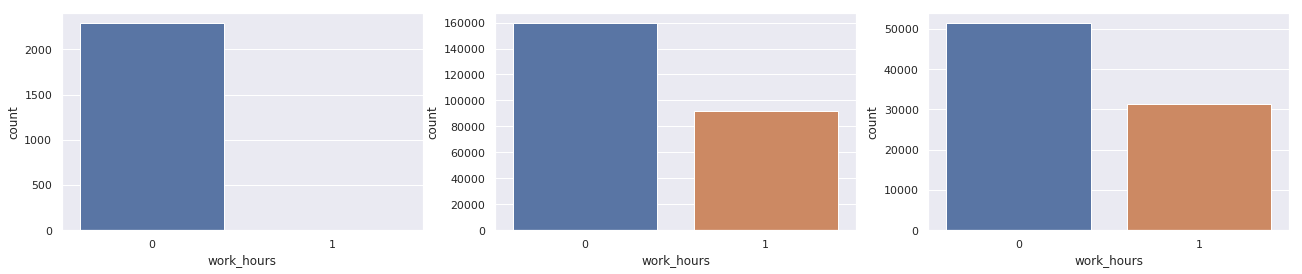

In [54]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="work_hours", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="work_hours", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="work_hours", data=test_df_plot, ax=axes[2]); # Test

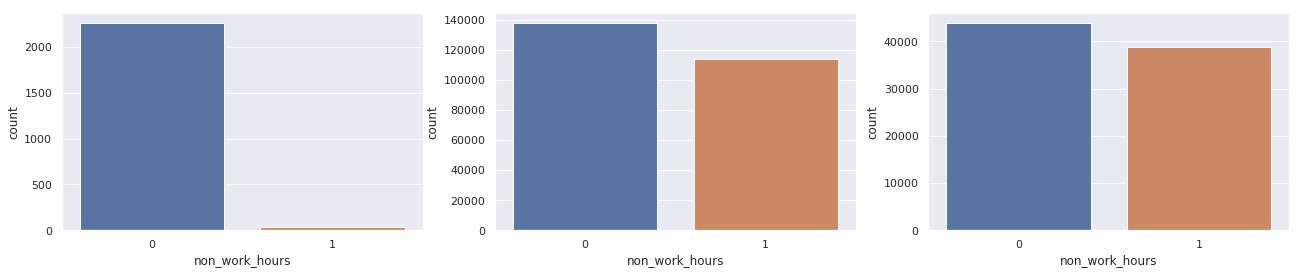

In [55]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="non_work_hours", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="non_work_hours", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="non_work_hours", data=test_df_plot, ax=axes[2]); # Test

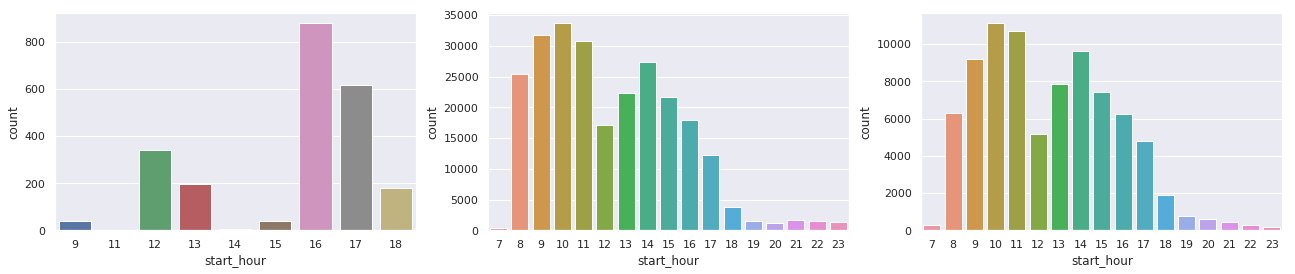

In [34]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="start_hour", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_hour", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="start_hour", data=test_df_plot, ax=axes[2]); # Test

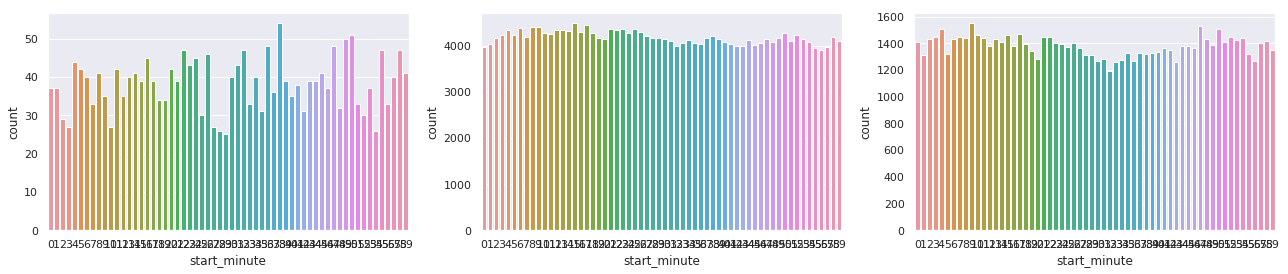

In [335]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="start_minute", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_minute", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="start_minute", data=test_df_plot, ax=axes[2]); # Test

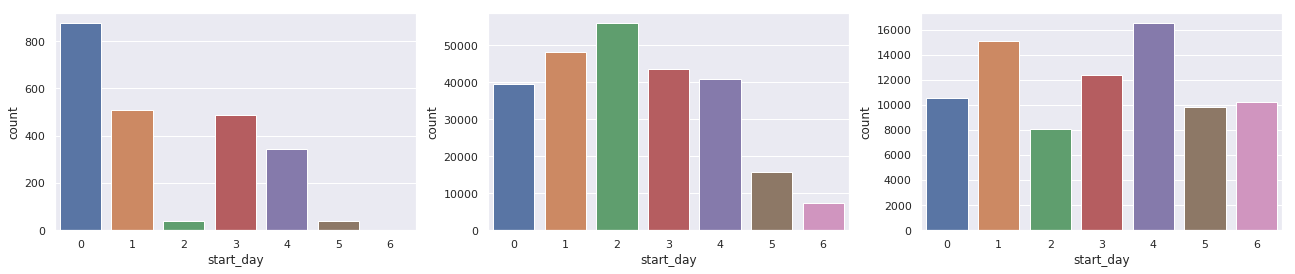

In [35]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="start_day", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_day", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="start_day", data=test_df_plot, ax=axes[2]); # Test

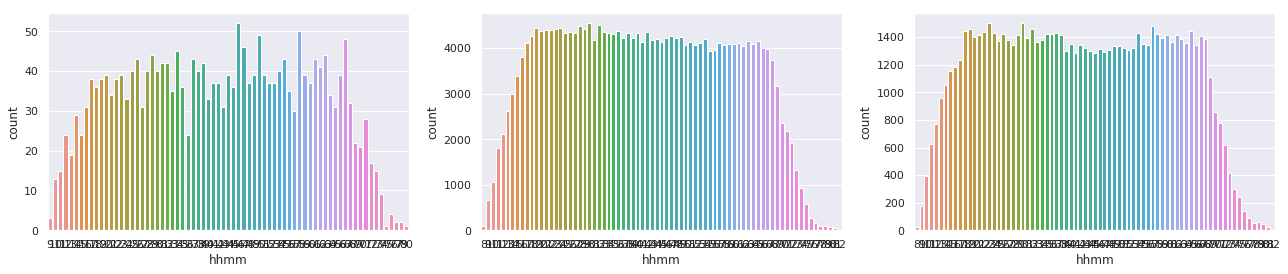

In [77]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="hhmm", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="hhmm", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="hhmm", data=test_df_plot, ax=axes[2]); # Test

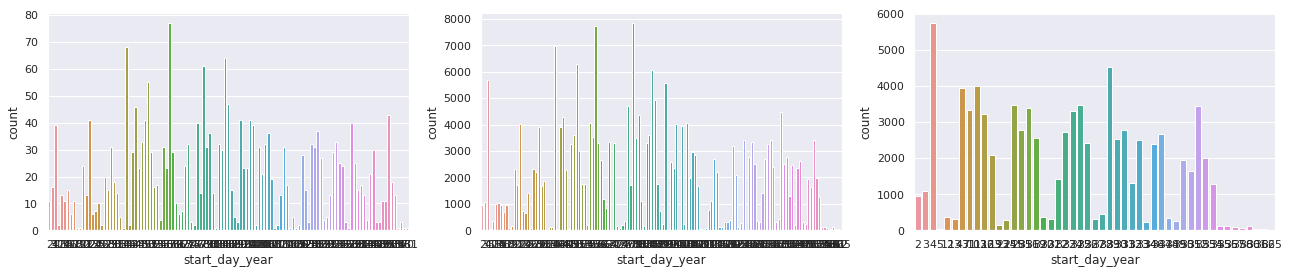

In [266]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="start_day_year", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_day_year", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="start_day_year", data=test_df_plot, ax=axes[2]); # Test

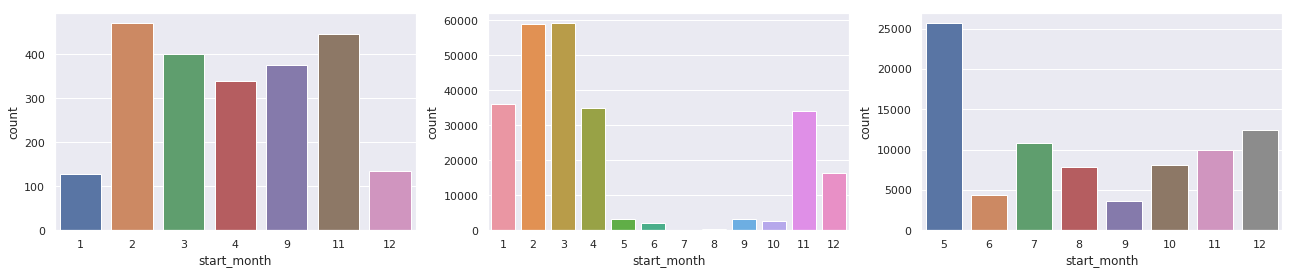

In [90]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="start_month", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="start_month", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="start_month", data=test_df_plot, ax=axes[2]); # Test

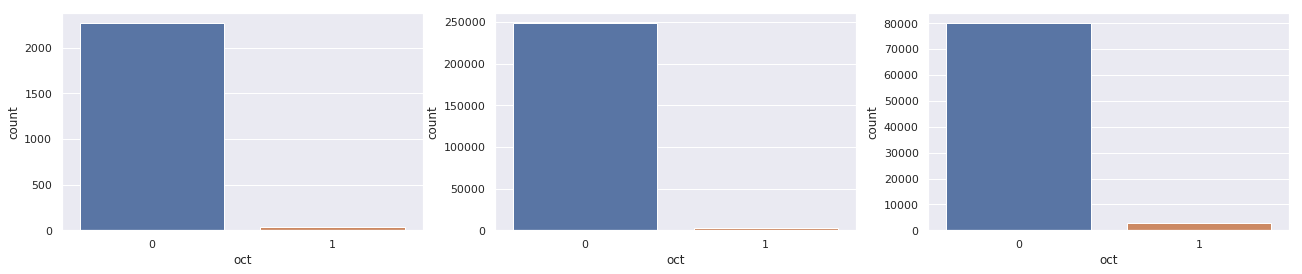

In [149]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="oct", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="oct", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="oct", data=test_df_plot, ax=axes[2]); # Test

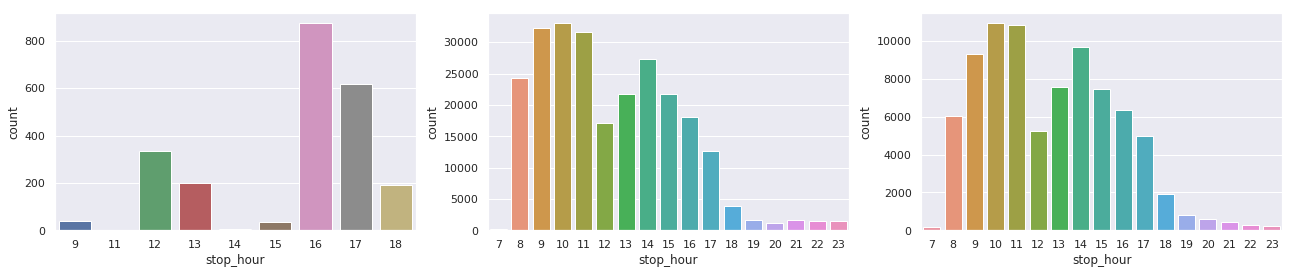

In [100]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="stop_hour", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="stop_hour", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="stop_hour", data=test_df_plot, ax=axes[2]); # Test

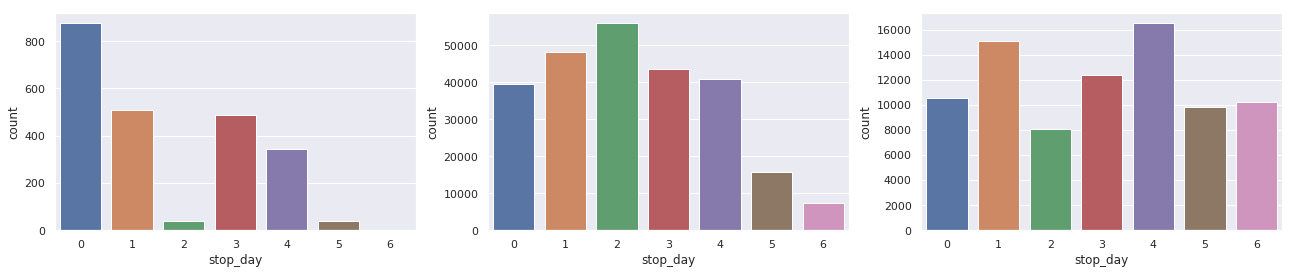

In [101]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="stop_day", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="stop_day", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="stop_day", data=test_df_plot, ax=axes[2]); # Test

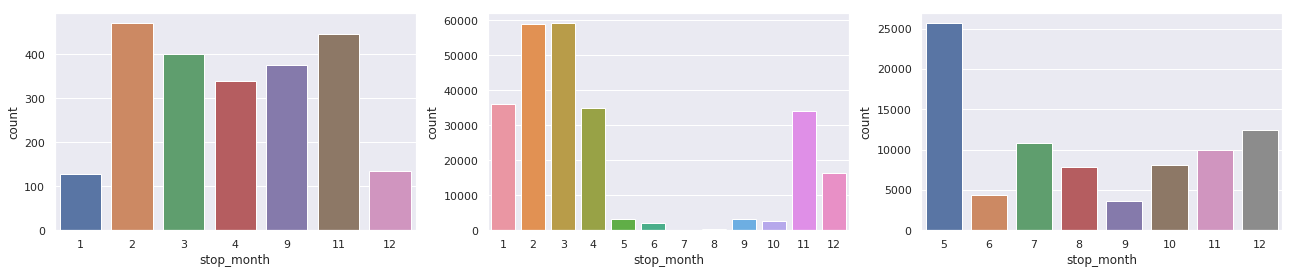

In [102]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="stop_month", data=train_df_plot[train_df_plot.target==1], ax=axes[0]) # Alice
sns.countplot(x="stop_month", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="stop_month", data=test_df_plot, ax=axes[2]); # Test

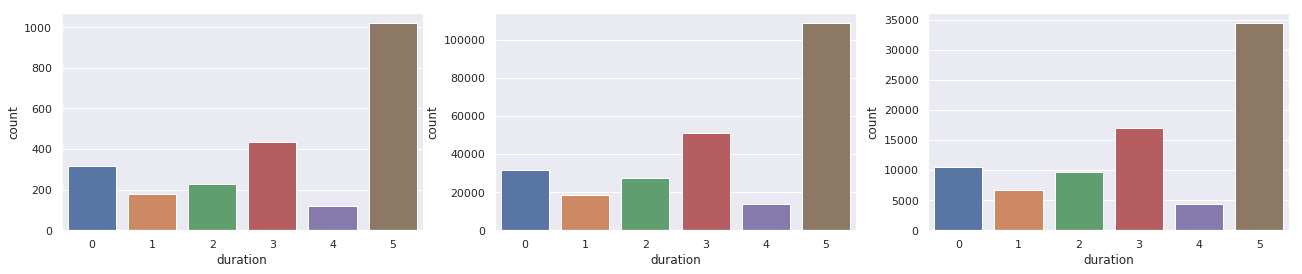

In [91]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="duration", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="duration", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="duration", data=test_df_plot, ax=axes[2]); # Test

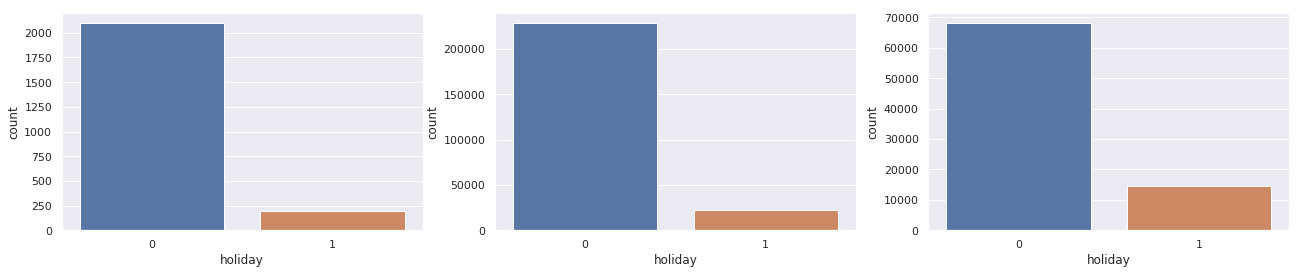

In [92]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="holiday", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="holiday", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="holiday", data=test_df_plot, ax=axes[2]); # Test

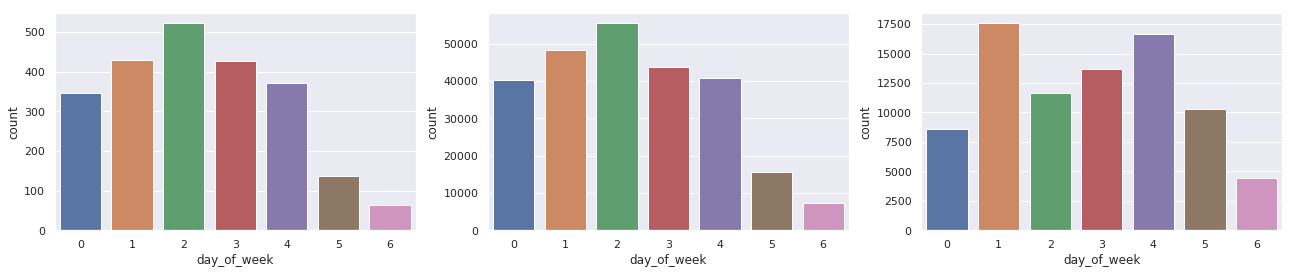

In [342]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="day_of_week", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="day_of_week", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="day_of_week", data=test_df_plot, ax=axes[2]); # Test

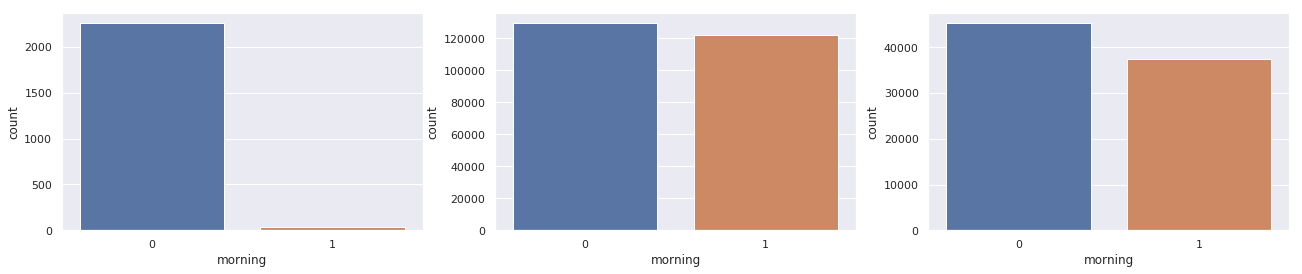

In [94]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="morning", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="morning", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="morning", data=test_df_plot, ax=axes[2]); # Test

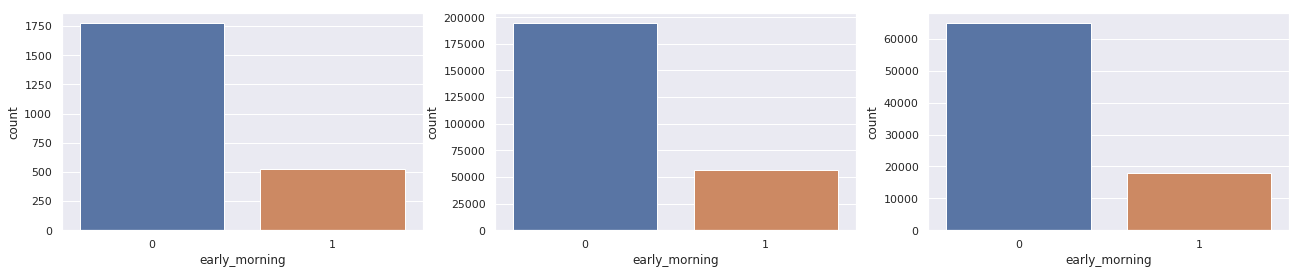

In [134]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="early_morning", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="early_morning", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="early_morning", data=test_df_plot, ax=axes[2]); # Test

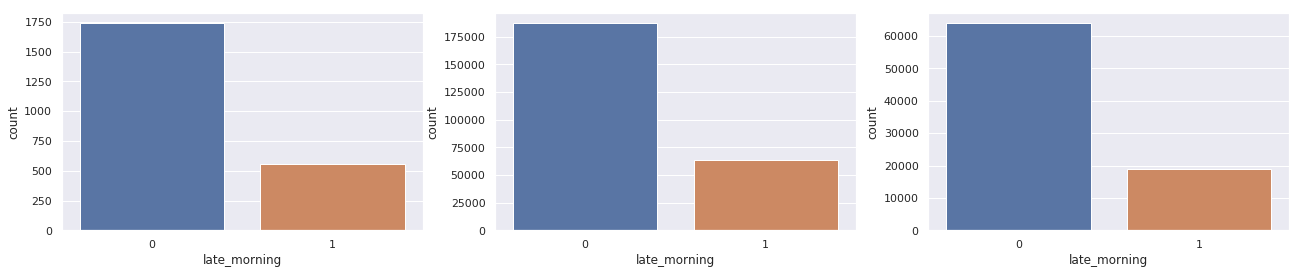

In [135]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="late_morning", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="late_morning", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="late_morning", data=test_df_plot, ax=axes[2]); # Test

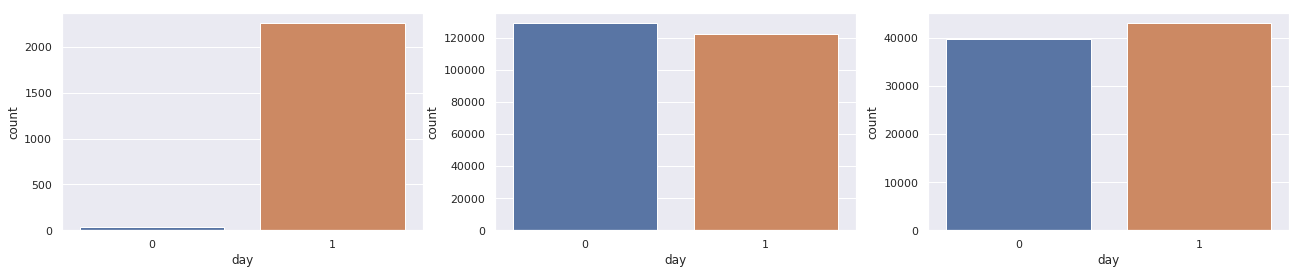

In [95]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="day", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="day", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="day", data=test_df_plot, ax=axes[2]); # Test

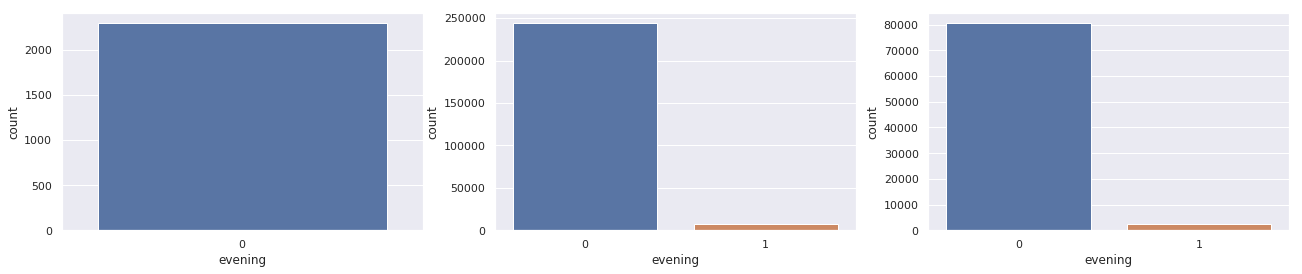

In [96]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="evening", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="evening", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="evening", data=test_df_plot, ax=axes[2]); # Test

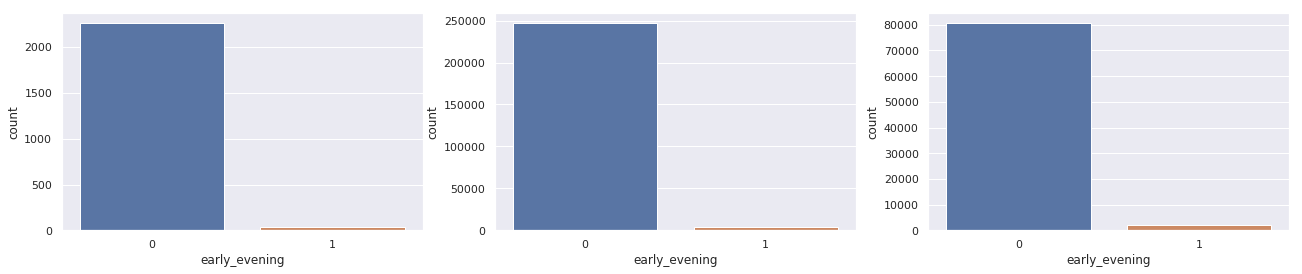

In [193]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="early_evening", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="early_evening", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="early_evening", data=test_df_plot, ax=axes[2]); # Test

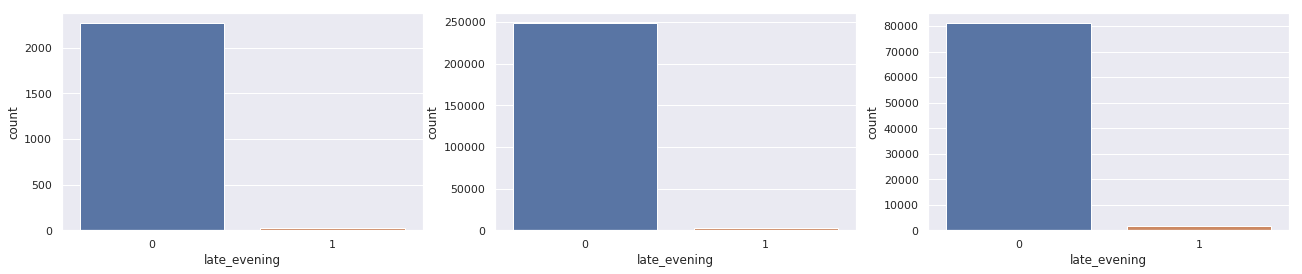

In [194]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="late_evening", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="late_evening", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="late_evening", data=test_df_plot, ax=axes[2]); # 

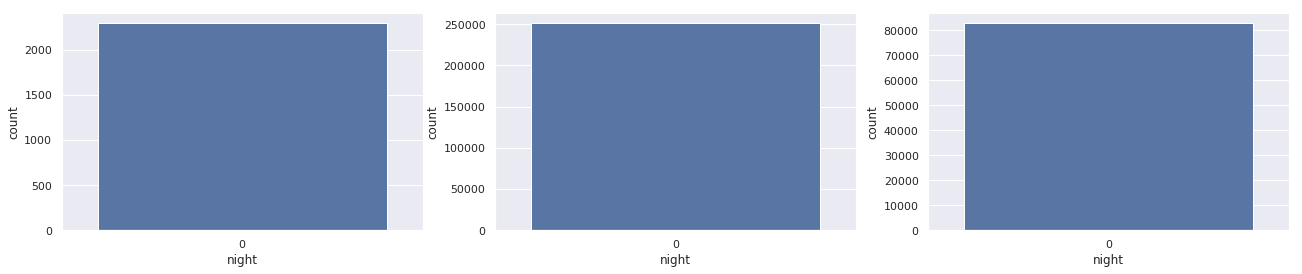

In [97]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="night", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="night", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="night", data=test_df_plot, ax=axes[2]); # Test

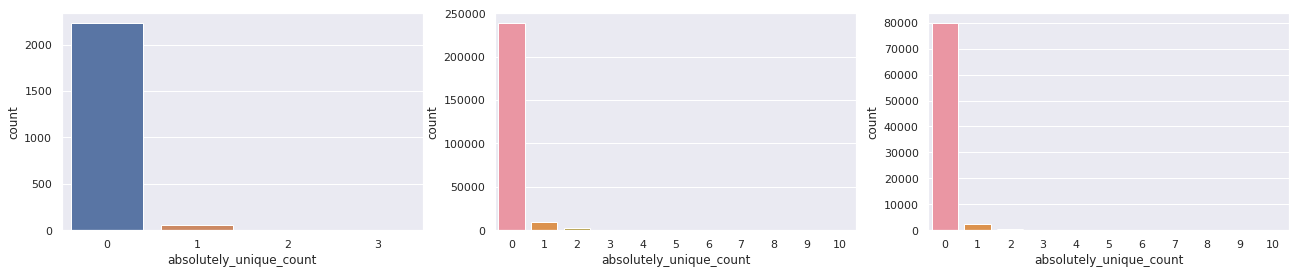

In [98]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="absolutely_unique_count", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="absolutely_unique_count", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="absolutely_unique_count", data=test_df_plot, ax=axes[2]); # Test

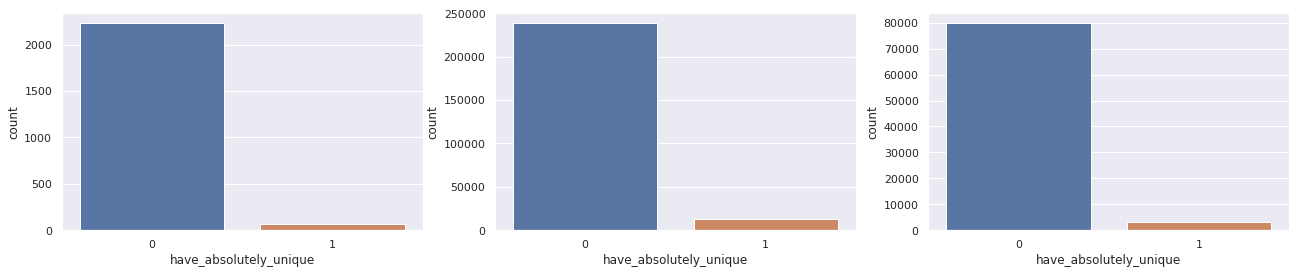

In [130]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="have_absolutely_unique", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="have_absolutely_unique", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="have_absolutely_unique", data=test_df_plot, ax=axes[2]); # Test

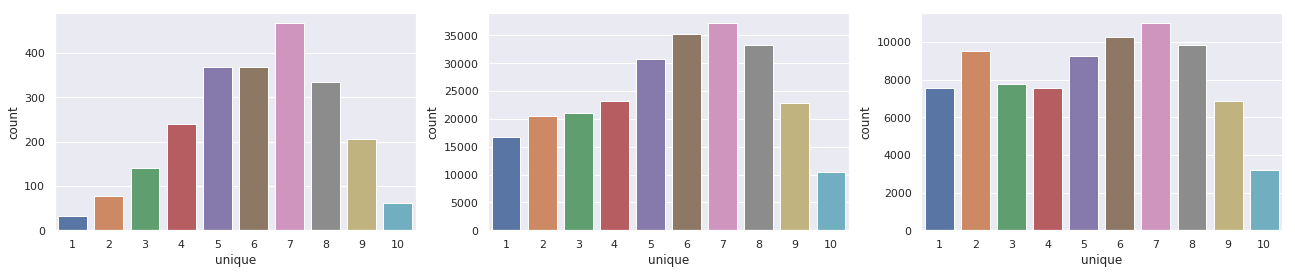

In [179]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="unique", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="unique", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="unique", data=test_df_plot, ax=axes[2]); # Test

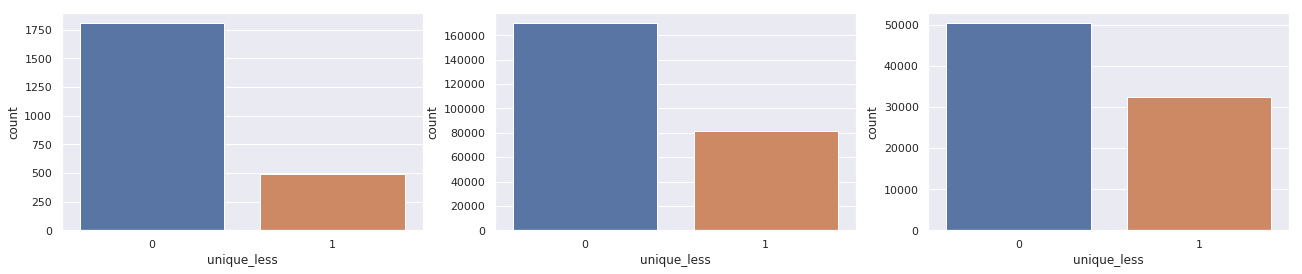

In [141]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="unique_less", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="unique_less", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="unique_less", data=test_df_plot, ax=axes[2]); # Test

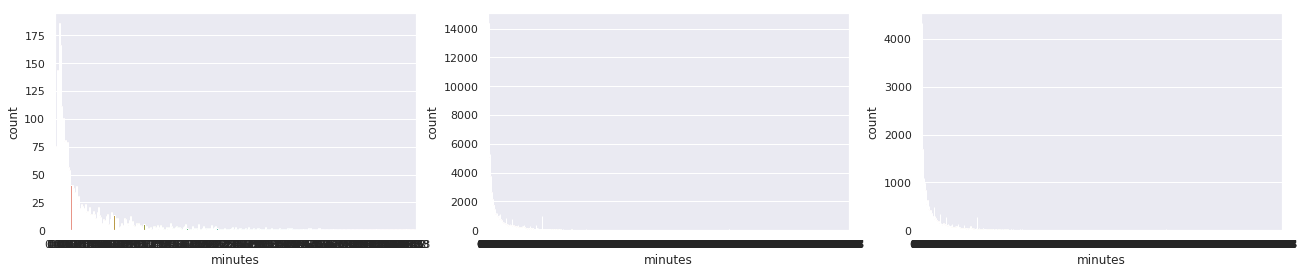

In [99]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="minutes", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="minutes", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="minutes", data=test_df_plot, ax=axes[2]); # Test

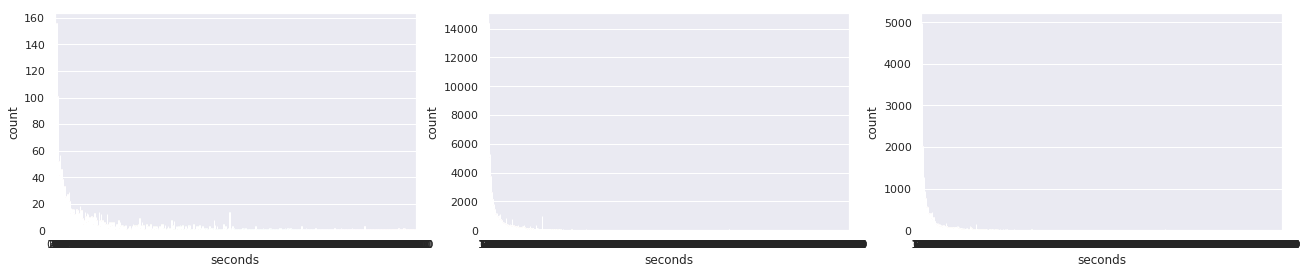

In [345]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="seconds", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="seconds", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="seconds", data=test_df_plot, ax=axes[2]); # Test

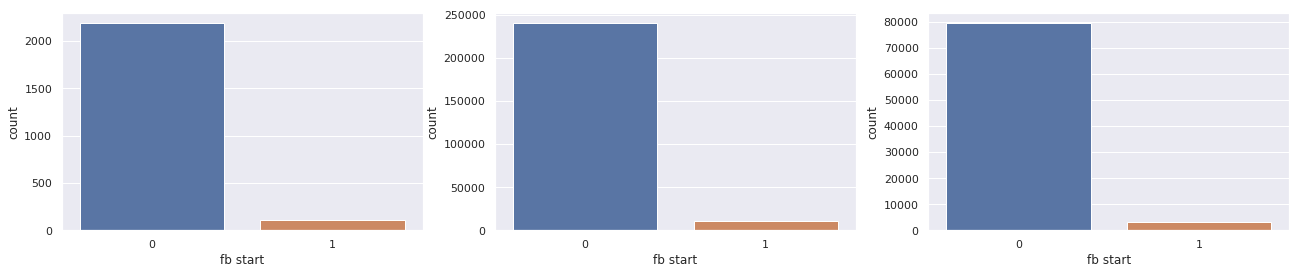

In [108]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="fb start", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="fb start", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="fb start", data=test_df_plot, ax=axes[2]); # Test

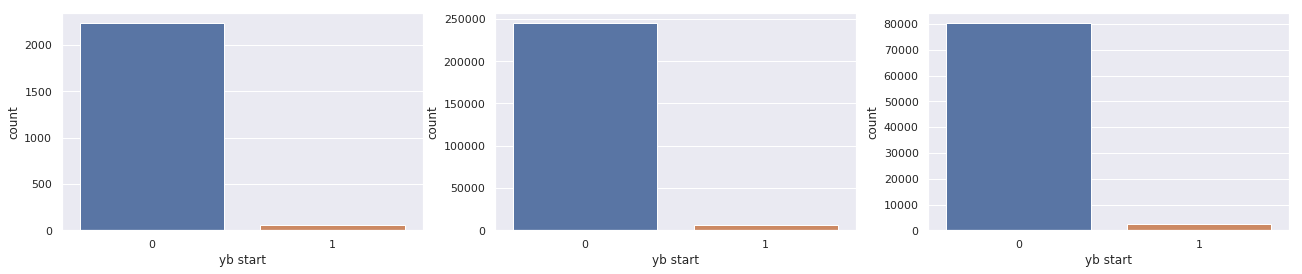

In [109]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="yb start", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="yb start", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="yb start", data=test_df_plot, ax=axes[2]); # Test

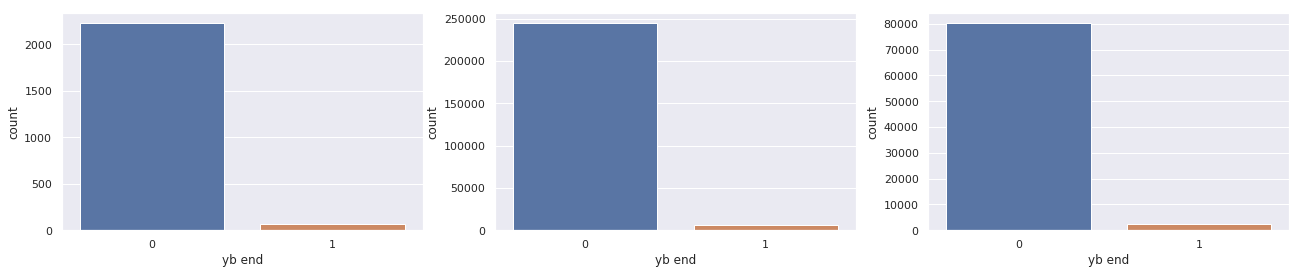

In [110]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="yb end", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="yb end", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="yb end", data=test_df_plot, ax=axes[2]); # Test

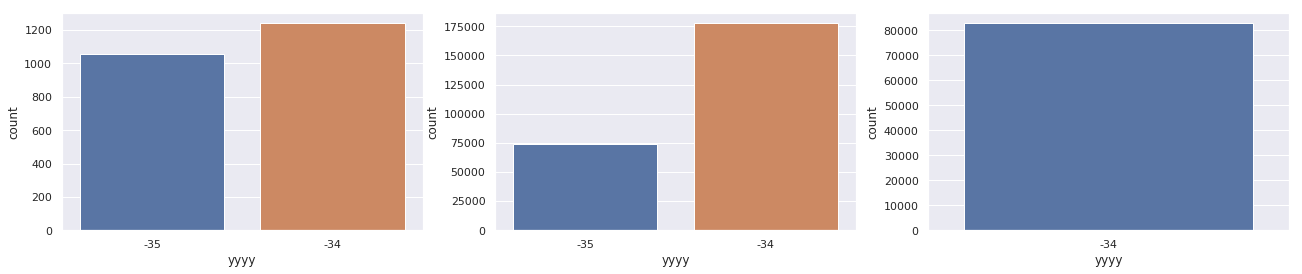

In [112]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="yyyy", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="yyyy", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="yyyy", data=test_df_plot, ax=axes[2]); # Test

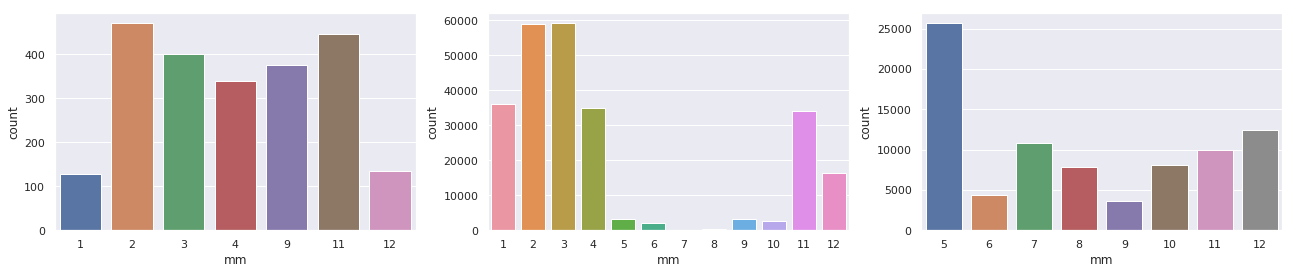

In [113]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="mm", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="mm", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="mm", data=test_df_plot, ax=axes[2]); # Test

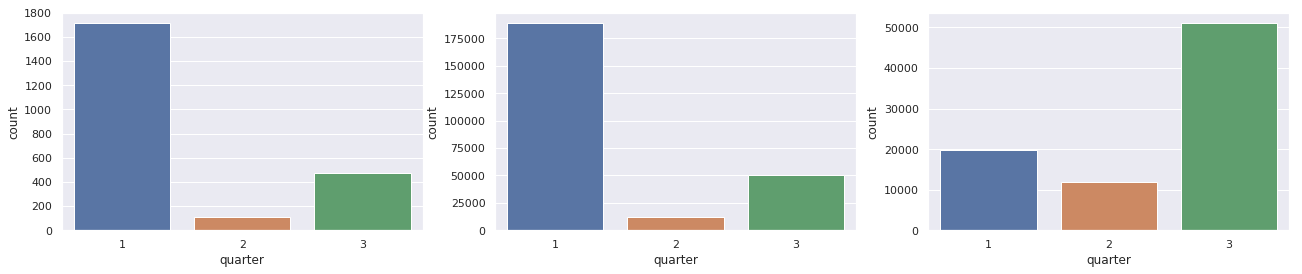

In [201]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="quarter", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="quarter", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="quarter", data=test_df_plot, ax=axes[2]); # Test

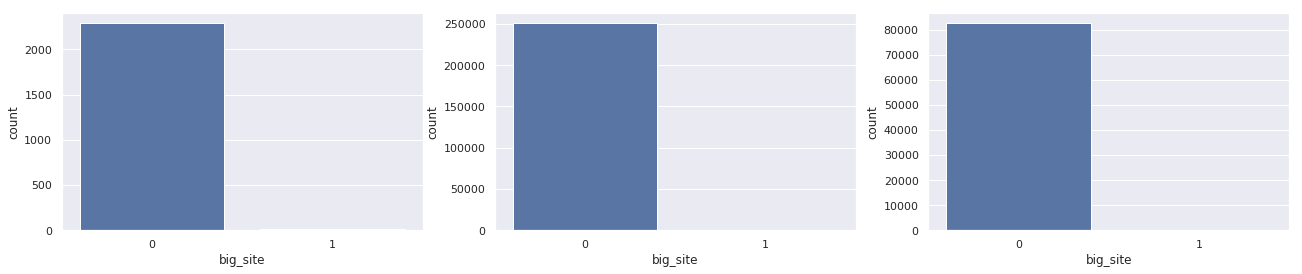

In [127]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="big_site", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="big_site", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="big_site", data=test_df_plot, ax=axes[2]); # Test

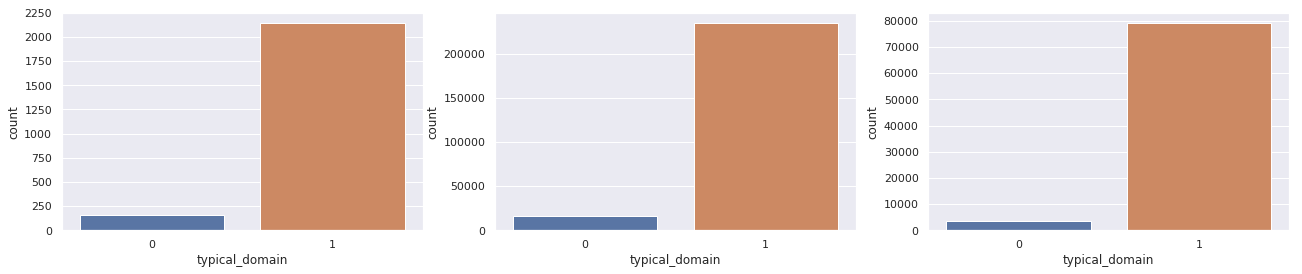

In [128]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="typical_domain", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="typical_domain", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="typical_domain", data=test_df_plot, ax=axes[2]); # Test

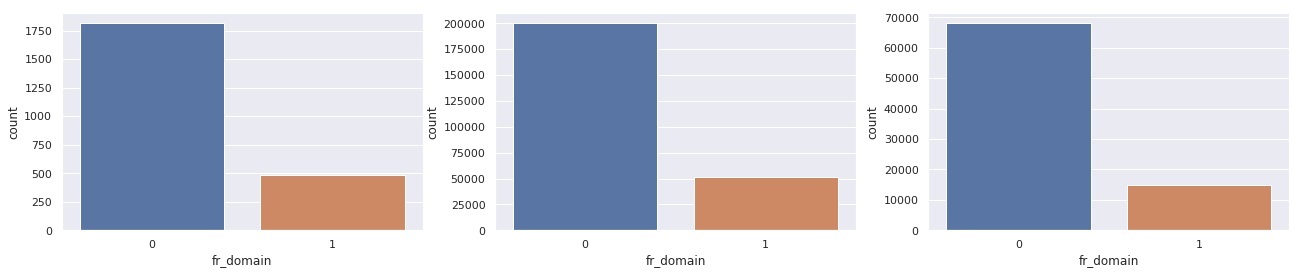

In [222]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="fr_domain", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="fr_domain", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="fr_domain", data=test_df_plot, ax=axes[2]); # Test

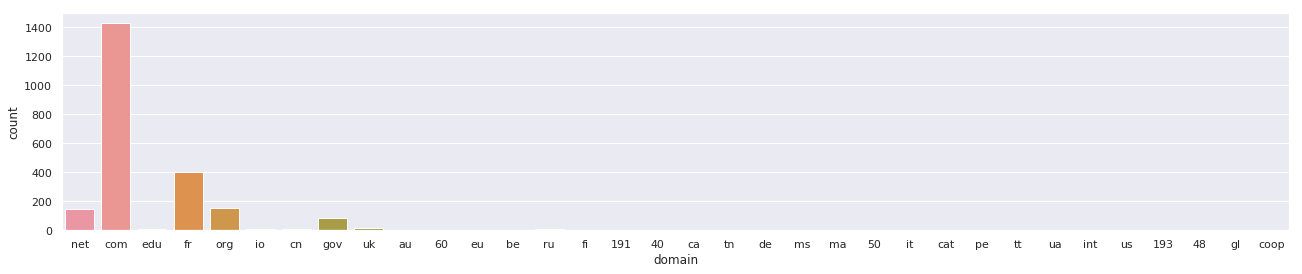

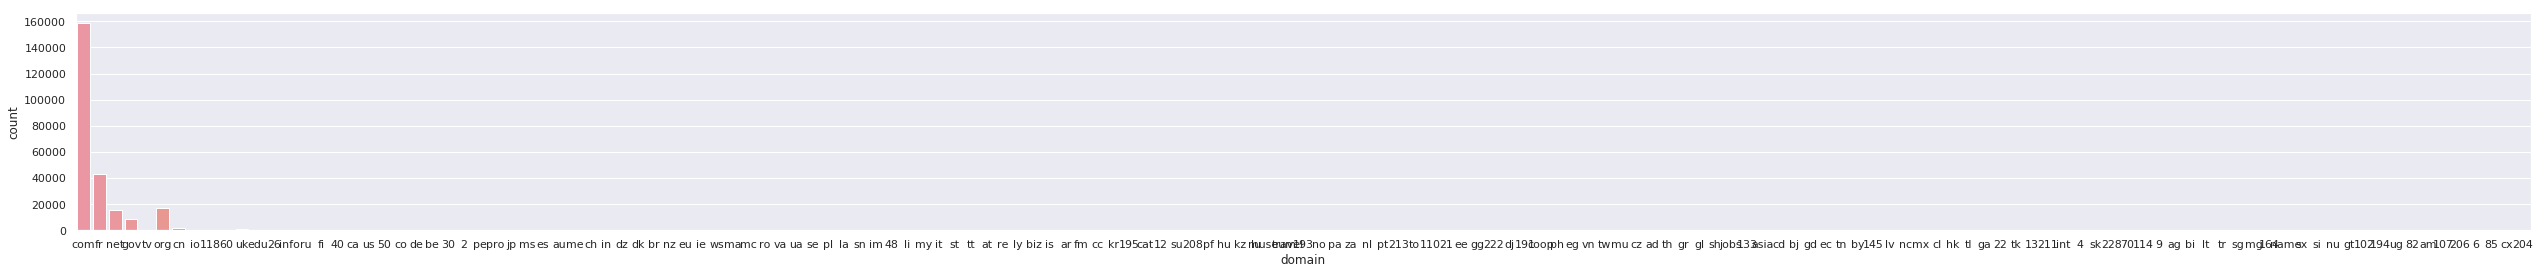

In [219]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,4))
sns.countplot(x="domain", data=train_df_plot[train_df_plot['target'] ==1]) # Alice
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(44,4))
sns.countplot(x="domain", data=train_df_plot[train_df_plot['target'] ==0])
# sns.countplot(x="domain", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
# sns.countplot(x="domain", data=test_df_plot, ax=axes[2]); # Test

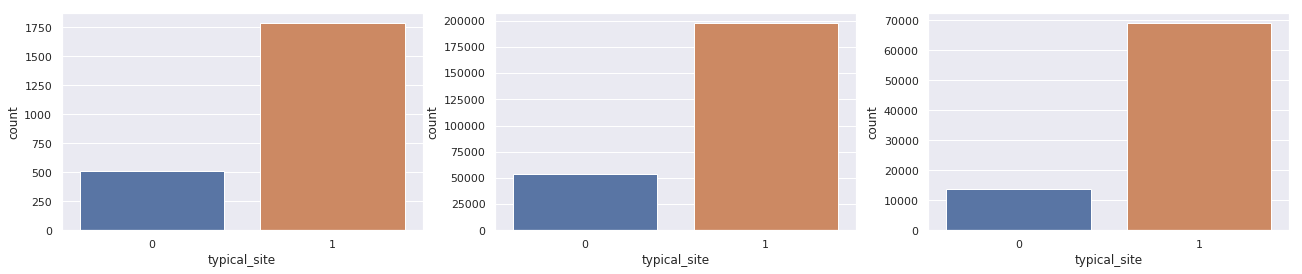

In [207]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="typical_site", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="typical_site", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="typical_site", data=test_df_plot, ax=axes[2]); # Test

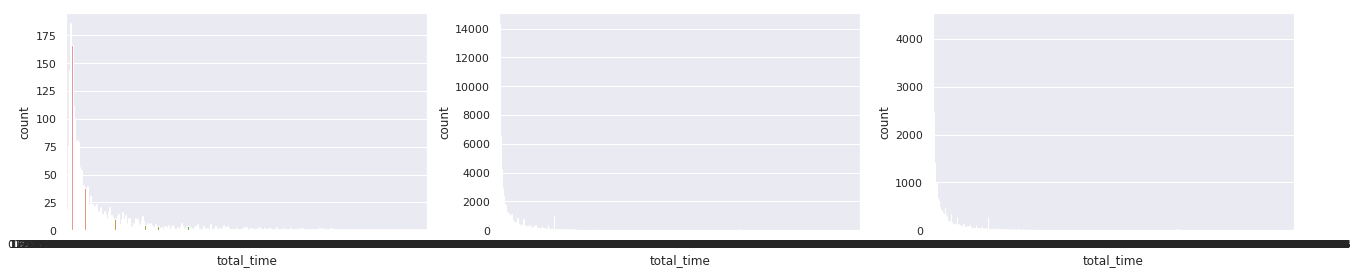

In [202]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="total_time", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="total_time", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="total_time", data=test_df_plot, ax=axes[2]); # Test

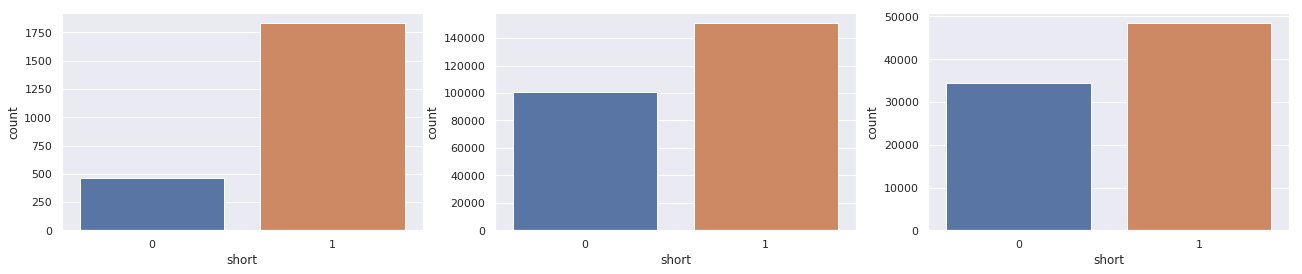

In [211]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="short", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="short", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="short", data=test_df_plot, ax=axes[2]); # Test

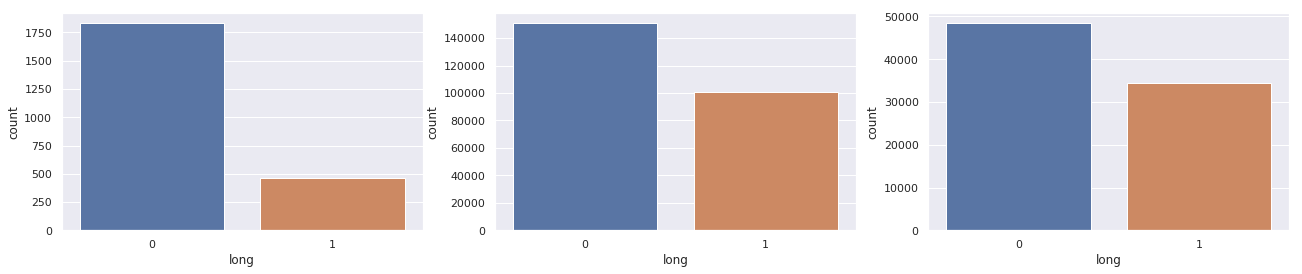

In [215]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="long", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="long", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="long", data=test_df_plot, ax=axes[2]); # Test

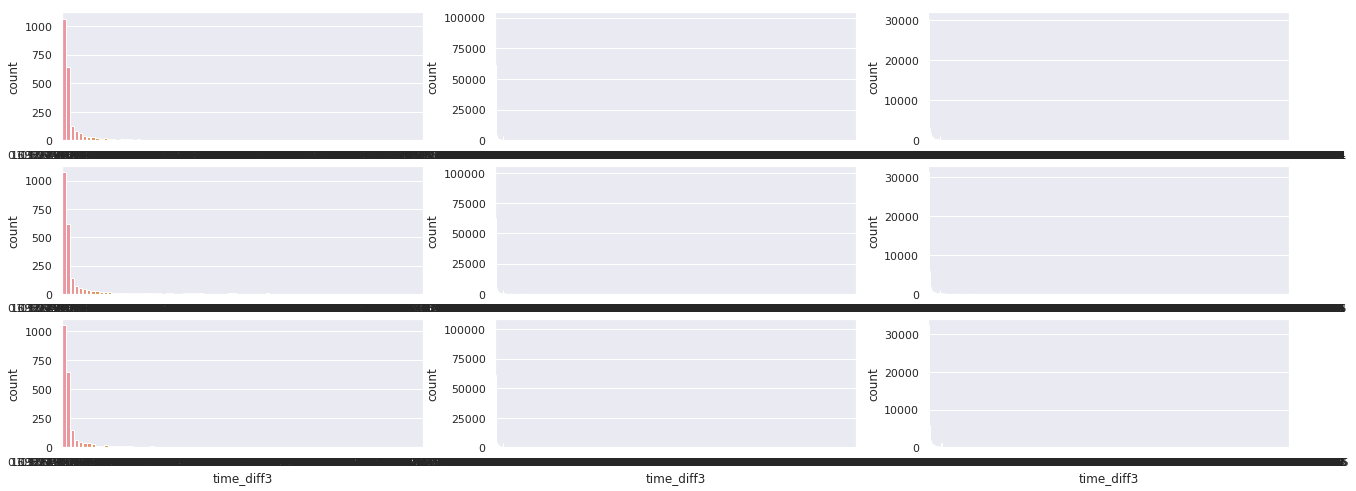

In [300]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(22,8))
sns.countplot(x="time_diff1", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0][0]) # Alice
sns.countplot(x="time_diff1", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[0][1]) # Not Alice
sns.countplot(x="time_diff1", data=test_df_plot, ax=axes[0][2]); # Test

sns.countplot(x="time_diff2", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[1][0]) # Alice
sns.countplot(x="time_diff2", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1][1]) # Not Alice
sns.countplot(x="time_diff2", data=test_df_plot, ax=axes[1][2]); # Test

sns.countplot(x="time_diff3", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[2][0]) # Alice
sns.countplot(x="time_diff3", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[2][1]) # Not Alice
sns.countplot(x="time_diff3", data=test_df_plot, ax=axes[2][2]); # Test

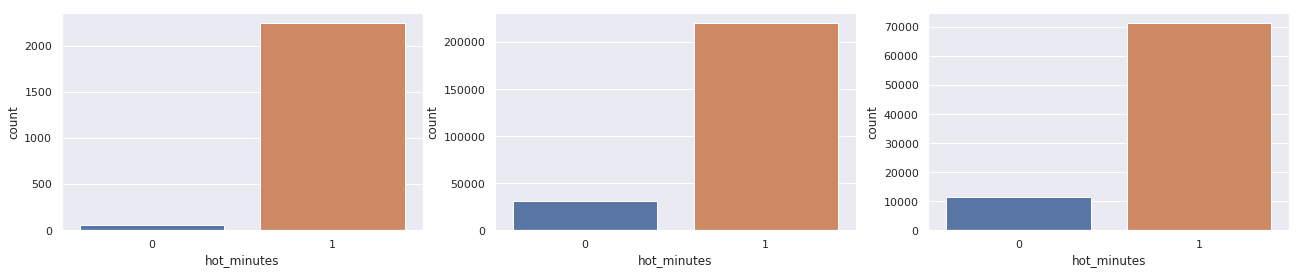

In [301]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
sns.countplot(x="hot_minutes", data=train_df_plot[train_df_plot['target'] ==1], ax=axes[0]) # Alice
sns.countplot(x="hot_minutes", data=train_df_plot[train_df_plot['target'] == 0], ax=axes[1]) # Not Alice
sns.countplot(x="hot_minutes", data=test_df_plot, ax=axes[2]); # Test

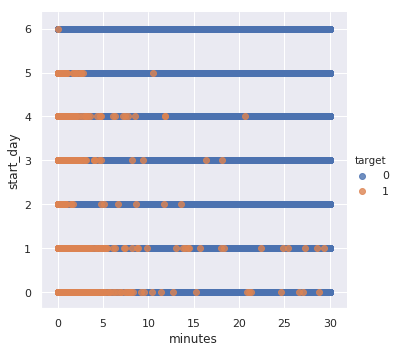

In [287]:
sns.lmplot('minutes', 'start_day', data=train_df_plot, hue='target', fit_reg=False)

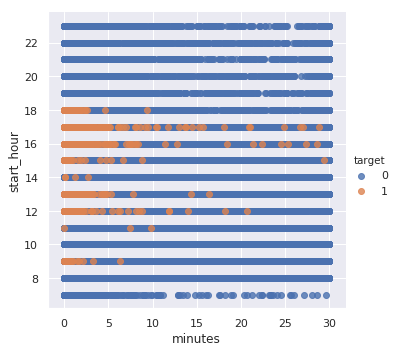

In [170]:
sns.lmplot('minutes', 'start_hour', data=train_df_plot, hue='target', fit_reg=False)

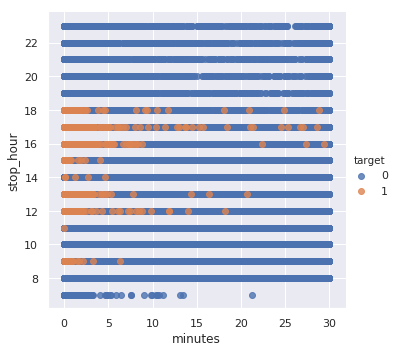

In [158]:
sns.lmplot('minutes', 'stop_hour', data=train_df_plot, hue='target', fit_reg=False)

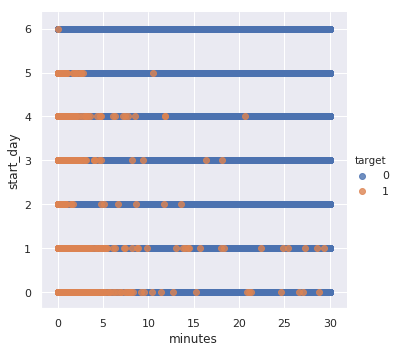

In [171]:
sns.lmplot('minutes', 'start_day', data=train_df_plot, hue='target', fit_reg=False)

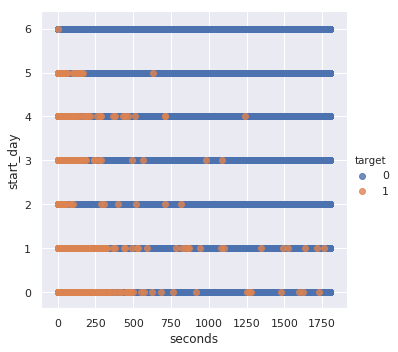

In [186]:
sns.lmplot('seconds', 'start_day', data=train_df_plot, hue='target', fit_reg=False)

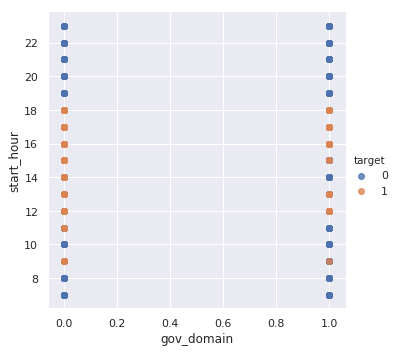

In [228]:
sns.lmplot('gov_domain', 'start_hour', data=train_df_plot, hue='target', fit_reg=False)

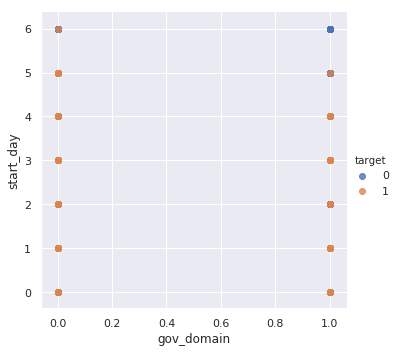

In [332]:
sns.lmplot('gov_domain', 'start_day', data=train_df_plot, hue='target', fit_reg=False)

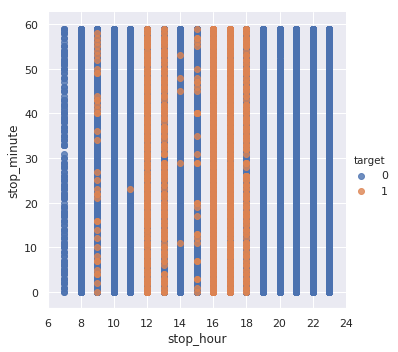

In [356]:
sns.lmplot('stop_hour', 'stop_minute', data=train_df_plot, hue='target', fit_reg=False)

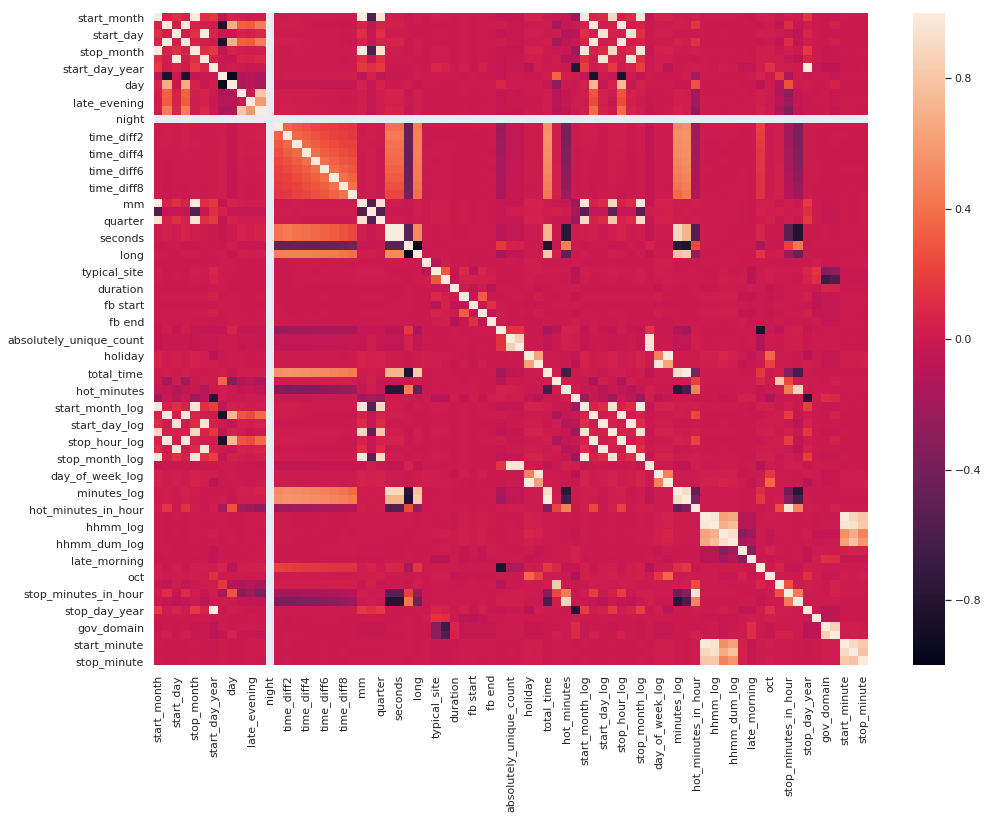

In [361]:
plt.figure(figsize = (16,12))

sns.heatmap(full_add_df.corr())

### Train model

In [57]:
#what about CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer


sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_new = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_new = cv.transform(inp_test_file)

In [86]:
dummies_cols = [
    'morning',
    'evening',
    'day',
    'night',
    'start_hour',
    'start_day',
    'start_month',
    'start_day_year',
    'yyyy',
    'mm',
    'short',
    'long',
    'work_hours',
    'non_work_hours',
    'hot_minutes',
    'hot_minutes_in_hour',
    'unique_less',
    'stop_minutes_in_hour',
    'hot_minutes_by_day',
    'gov_domain_hours',
    'is_evening',
    'end_time_eve',
    'is_daylight',
    'sites_per_session',
]
scaled_cols = [
    'start_hour_log',
    'start_minute_log',
    'end_time',
    'stm_per_weekday',
    'sec_per_season',
    'time_per_site',
    'seconds_log',
    'minutes_log',
    'total_time',
    'hhmm_log',
    '1_first',
    '1_insess',
    '1_last',
    '1_per_sessmore1',
    '2_per_sess'
]
tmp_scaled = StandardScaler().fit_transform(full_add_df[scaled_cols])
full_add_df_dummies  = pd.get_dummies(full_add_df[dummies_cols] , columns=dummies_cols)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [87]:
X_train = csr_matrix(hstack([X_train_new, 
                                tmp_scaled[:idx_split,:],
                                full_add_df_dummies[:idx_split],
                                ]))
X_test = csr_matrix(hstack([X_test_new, 
                                tmp_scaled[idx_split:,:],
                                full_add_df_dummies[idx_split:],
                               ]))

In [88]:
%%time
get_auc_lr_valid(X_train, y_train) 

CPU times: user 21.1 s, sys: 152 ms, total: 21.2 s
Wall time: 21.3 s


0.9857355235762697

In [89]:
%%time
time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]
logit = LogisticRegression(C=1.0, random_state=17, solver='liblinear')
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=3)

CPU times: user 104 ms, sys: 299 ms, total: 403 ms
Wall time: 56 s


In [90]:
cv_scores, cv_scores.mean() 

(array([0.76907352, 0.88595234, 0.96067586, 0.96599366, 0.93610908,
        0.98111113, 0.91196787, 0.96580207, 0.95900642, 0.98482422]),
 0.9320516175094543)

In [91]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [92]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_, logit_grid_searcher.best_estimator_

(0.9323991494054951,
 {'C': 0.5994842503189409},
 LogisticRegression(C=0.5994842503189409, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False))

In [93]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_test_pred3, '4mart2.csv') #0.95403